## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.stats import spearmanr
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
import seaborn as sns
sys.path.append("../funcs")
import proteomics as prot

import plotnine
from plotnine import ggplot, geom_point, geom_violin, geom_boxplot, geom_jitter
from plotnine import aes, stat_smooth, facet_wrap, scale_fill_manual, scale_shape_manual, theme_bw, element_blank
from plotnine import guides, theme, labs, element_text, guide_legend

In [2]:
# File paths
COHORT_CORRECTED_ACETYL_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/imputed_res/acetylome_X.parquet"
RAW_ACETYL_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/raw/acetylome_X.tsv.gz"
RAW_RES_ACETYL_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/raw_res/acetylome_raw_res_X.parquet"
RAW_PHOSPHO_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/raw/phosphoproteome_X.tsv.gz"
RAW_RES_PHOSPHO_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/raw_res/phosphoproteome_raw_res_X.parquet"
RNA_TPM_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/rna/tumor_rna_tpm_X.parquet"
H_MUT_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/mutational_signatures/Full_H_compressed_v1.1.tsv"
SAMPLE_MAP_PATH = "gs://cptac-pancan-getzlab/mapping/PanCan_Participant_freeze_mapping.tsv"
VAR_MAP_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/061721/var_map_full_v4.tsv"
SSGSEA_RNA_PATH = "/home/yakiyama/CPTAC_PanCan_2021/analysis_files/ssGSEA/rna_z-combined.gct"
SSGSEA_PROT_PATH = "/home/yakiyama/CPTAC_PanCan_2021/analysis_files/ssGSEA/prot-combined.gct"
HISTONE_GS_PATH = "../analysis_files/genesets/Histone_genes_curated_v1.0.tsv"
SAMPLE_META_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/clinical/acetylome_meta_data.tsv"

In [3]:
# Load data
raw_acetyl_df = pd.read_csv(RAW_ACETYL_PATH, sep='\t', index_col=0).T
raw_phospho_df = pd.read_csv(RAW_PHOSPHO_PATH, sep='\t', index_col=0).T
raw_res_acetyl_df = pd.read_parquet(RAW_RES_ACETYL_PATH).T
raw_res_phospho_df = pd.read_parquet(RAW_RES_PHOSPHO_PATH).T
imputed_acetyl_df = pd.read_parquet(COHORT_CORRECTED_ACETYL_PATH).T
H_mut = pd.read_csv(H_MUT_PATH, sep='\t', index_col=0)
sample_map = pd.read_csv(SAMPLE_MAP_PATH, sep='\t')
var_map = pd.read_csv(VAR_MAP_PATH, sep='\t', index_col=0)

H_mut.index = H_mut.index.map(sample_map.set_index('WXS').to_dict()['Proteome_Sample_ID'])
H_mut_norm = H_mut.div(H_mut.sum(1), 0)
H_mut['cohort'] = H_mut.index.map(sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort']) 
H_mut_norm['cohort'] = H_mut_norm.index.map(sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort']) 

ssgsea_uniq_df, ssgsea_uniq_rna, ssgsea_uniq_prot = prot.load_ssgsea_results(
    SSGSEA_RNA_PATH, SSGSEA_PROT_PATH
)

histone_gs_df = pd.read_csv(HISTONE_GS_PATH, sep='\t', encoding='latin-1')

meta_df = pd.read_csv(SAMPLE_META_PATH, sep='\t', index_col=0)

/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
# Save LUAD and LSCC samples and distinguish between smokers and non-smokers 
# based on mutational signature weights
# Exclude female samples
luad_s = H_mut[H_mut['cohort'].isin(['LUAD'])].index
assert not meta_df.loc[luad_s]['sex'].isna().any()
lscc_s = H_mut[H_mut['cohort'].isin(['LSCC'])].index
hnscc_s = H_mut[H_mut['cohort'].isin(['HNSCC'])].index
luad_s = luad_s[luad_s.map(lambda x: meta_df.loc[x, 'sex']=='Male')]
lscc_s = lscc_s[lscc_s.map(lambda x: meta_df.loc[x, 'sex']=='Male')]

luad_smokers = H_mut[(H_mut.index.isin(luad_s)) & (H_mut['Tobacco Smoking']>=50) & 
                     (H_mut_norm['Tobacco Smoking']>=0.4)].index
luad_nonsmokers = [x for x in luad_s if x not in luad_smokers]

luad_female_s = H_mut[H_mut['cohort']=='LUAD'].index
luad_female_s = luad_female_s[luad_female_s.map(lambda x: meta_df.loc[x, 'sex']=='Female')]

lscc_female_s = H_mut[H_mut['cohort']=='LSCC'].index
lscc_female_s = lscc_female_s[lscc_female_s.map(lambda x: meta_df.loc[x, 'sex']=='Female')]

In [5]:
len(luad_s)

71

In [7]:
len(lscc_s)

86

## 1. Check tobacco smoking mutagenesis and sex

* Triangles for LSCC and Circle for LUAD
* Add p-value
* In text, add removing females

In [16]:
smoke_h_mut = H_mut[H_mut['cohort'].isin(['LSCC', 'LUAD'])].copy()
smoke_h_mut['sex'] = smoke_h_mut.index.map(meta_df.to_dict()['sex'])
smoke_h_mut_log = smoke_h_mut.copy()
smoke_h_mut_log['Tobacco Smoking'] = smoke_h_mut_log['Tobacco Smoking'].map(lambda x: np.log10(x+1))
smoke_h_mut_log['cohort_shape'] = smoke_h_mut_log['cohort'].map({"LUAD":"o", "LSCC":"^"})

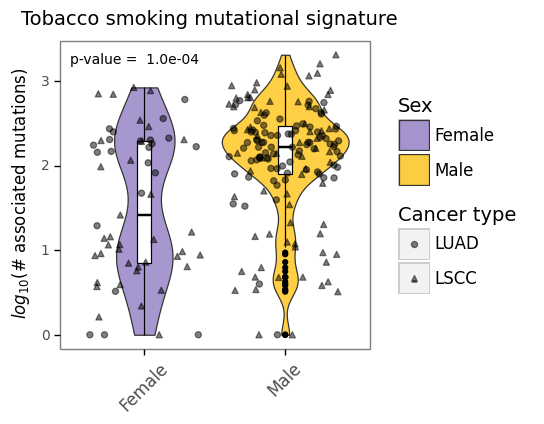

In [17]:
p = (ggplot(smoke_h_mut_log, aes(x = 'sex', y='Tobacco Smoking')) 
     + geom_violin(aes(fill = 'sex'), alpha = 0.75) 
     + geom_boxplot(width=0.1,colour="black") 
     + geom_jitter(aes(shape="factor(cohort_shape)"), alpha = 0.5, size=2)
     + scale_fill_manual(values=["#8A74C0","#FFC107"], guide="none")
     + scale_shape_manual(name='Cancer type', values=["o", "^"], labels=['LUAD', 'LSCC'])
     + theme_bw(base_size = 16) 
     + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank())
     + labs(title="Tobacco smoking mutational signature", y= r"$log_{10}$(# associated mutations)", x= "") 
     + theme(axis_text_x=element_text(angle=45, size=12), figure_size=(4,4), axis_title_y = element_text(size=12), 
             axis_text_y=element_text(size=10), plot_title=element_text(size=14)) 
     + guides(fill=guide_legend(title="Sex")) 
     + theme(legend_text=element_text(size=12), legend_title=element_text(size=14))
    )
fig = p.draw()
axs = fig.get_axes()
stat, pval = ranksums(smoke_h_mut_log[smoke_h_mut_log['sex'] == 'Male']['Tobacco Smoking'], 
                      smoke_h_mut_log[smoke_h_mut_log['sex'] == 'Female']['Tobacco Smoking'])
fig.text(s=f"p-value = {pval: .1e}", x=0.15, y=0.825, size=10)
fig.savefig("../figures/histone_analysis/sex_smoking_violin.pdf", dpi=100, bbox_inches='tight')

# p = (ggplot(smoke_h_mut_log[smoke_h_mut_log['cohort']=='LSCC'], aes(x = 'sex', y='Tobacco Smoking')) 
#      + geom_violin(aes(fill = 'sex'), alpha = 0.75) 
#      + geom_boxplot(width=0.1,colour="black") 
#      + geom_jitter(alpha = 0.5, size=2) 
#      + scale_fill_manual(values=["#8A74C0","#FFC107"], guide="none")
#      + theme_bw(base_size = 20) 
#      + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank())
#      + labs(title="Tobacco smoking mutational signature (LSCC)", y= r"$log_{10}$(# associated mutations)", x= "") 
#      + theme(axis_text_x=element_text(angle=45, size=12), figure_size=(4,4), axis_title_y = element_text(size=12), 
#              axis_text_y=element_text(size=10), plot_title=element_text(size=14)) 
#      + guides(fill=guide_legend(title="Sex")) 
#      + theme(legend_text=element_text(size=12), legend_title=element_text(size=14))
#     )
# fig = p.draw()
# axs = fig.get_axes()

# p = (ggplot(smoke_h_mut_log[smoke_h_mut_log['cohort']=='LUAD'], aes(x = 'sex', y='Tobacco Smoking')) 
#      + geom_violin(aes(fill = 'sex'), alpha = 0.75) 
#      + geom_boxplot(width=0.1,colour="black") 
#      + geom_jitter(alpha = 0.5, size=2) 
#      + scale_fill_manual(values=["#8A74C0","#FFC107"], guide="none")
#      + theme_bw(base_size = 20) 
#      + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank())
#      + labs(title="Tobacco smoking mutational signature (LUAD)", y= r"$log_{10}$(# associated mutations)", x= "") 
#      + theme(axis_text_x=element_text(angle=45, size=12), figure_size=(4,4), axis_title_y = element_text(size=12), 
#              axis_text_y=element_text(size=10), plot_title=element_text(size=14)) 
#      + guides(fill=guide_legend(title="Sex")) 
#      + theme(legend_text=element_text(size=12), legend_title=element_text(size=14))
#     )
# fig = p.draw()
# axs = fig.get_axes()

## 2 Correlations for tobacco smoking mutageneesis and histone acetylation (correcting for protein abundance) within each cohort

In [6]:
# Run spearman correlation for acetylation and histone acetylation sites
# Use any acetylation site with at least 30% observations
obs_cutoff = 0.3
histone_geneSymbol_l = histone_gs_df[histone_gs_df['main_gene_group'].isin(
    ['H1', 'H2A variant', 'H2A', 'H2B', 'H2B variant', 'H3 variant', 
     'H2', 'H3', 'H4'])]['symbol'].unique()
histone_geneSymbol_l = [x for x in histone_geneSymbol_l if x in var_map['geneSymbol'].to_list()]
histone_geneSymbol_l.remove('UBN1')
histone_geneSymbol_l.remove('CABIN1')
histone_geneSymbol_l.remove('CENPA')

# luad_s = H_mut[H_mut['cohort'].isin(['LUAD'])].index
luad_raw_acetyl_df = raw_acetyl_df.loc[luad_s]
luad_corr_d = {}
for site in var_map[var_map['geneSymbol'].isin(histone_geneSymbol_l) & (var_map['feature']=='acetylome')].index:
    if site not in luad_raw_acetyl_df.columns:
        continue
    feature_s = luad_raw_acetyl_df[site].dropna()
    if len(feature_s) < len(luad_s) * obs_cutoff:
        continue
    corr, pval = spearmanr(feature_s, H_mut.loc[feature_s.index, 'Tobacco Smoking'])
    luad_corr_d[site] = {"corr":corr, "pval":pval, 'propMissing':1-len(feature_s)/len(luad_s)}
luad_corr_df = pd.DataFrame.from_dict(luad_corr_d).T
luad_corr_df['adj.P.Val'] = multipletests(luad_corr_df['pval'], method='fdr_bh')[1]
luad_corr_df['geneSymbol'] = luad_corr_df.index.map(var_map.to_dict()['geneSymbol'])
luad_corr_df[luad_corr_df['adj.P.Val']<0.15].sort_values('pval')

,corr,pval,propMissing,adj.P.Val,geneSymbol
NP_002097.1_K12kK14k_2_2_12_14,0.408122,0.000899,0.112676,0.091702,H2AZ1
NP_778225.1_K6k_1_1_6_6,0.422347,0.002503,0.309859,0.127670,H2BU1


In [70]:
#### Run spearman correlation for smoking and histone acetylation sites after correcting for protein abundance
histone_geneSymbol_l = histone_gs_df[histone_gs_df['main_gene_group'].isin(
    ['H1', 'H2A variant', 'H2A', 'H2B', 'H2B variant', 'H3 variant', 
     'H2', 'H3', 'H4'])]['symbol'].unique()
histone_geneSymbol_l = [x for x in histone_geneSymbol_l if x in var_map['geneSymbol'].to_list()]
histone_geneSymbol_l.remove('UBN1')
histone_geneSymbol_l.remove('CABIN1')
histone_geneSymbol_l.remove('CENPA')

# luad_s = H_mut[H_mut['cohort'].isin(['LUAD'])].index
luad_raw_res_acetyl_df = raw_res_acetyl_df.loc[luad_s]
luad_corr_d = {}
for site in var_map[var_map['geneSymbol'].isin(histone_geneSymbol_l) & (var_map['feature']=='acetylome')].index:
    if site not in luad_raw_res_acetyl_df.columns:
        continue
    feature_s = luad_raw_res_acetyl_df[site].dropna()
    if len(feature_s) < len(luad_s) * 0.3:
        continue
    corr, pval = spearmanr(feature_s, H_mut.loc[feature_s.index, 'Tobacco Smoking'])
    luad_corr_d[site] = {"corr":corr, "pval":pval, 'propMissing':1-len(feature_s)/len(luad_s)}
luad_corr_df = pd.DataFrame.from_dict(luad_corr_d).T
luad_corr_df['adj.P.Val'] = multipletests(luad_corr_df['pval'], method='fdr_bh')[1]
luad_corr_df['geneSymbol'] = luad_corr_df.index.map(var_map.to_dict()['geneSymbol'])
luad_corr_df.to_csv("../results/histone_tobacco/luad_smoke_histone_acetylation_spearman_v2.tsv", sep='\t')
luad_corr_df[luad_corr_df['adj.P.Val']<0.1].sort_values('pval')


,corr,pval,propMissing,adj.P.Val,geneSymbol
NP_005309.1_K180k_1_1_180_180,-0.448599,0.000669,0.239437,0.052152,H1-0
NP_002097.1_K12kK14k_2_2_12_14,0.388585,0.001648,0.112676,0.064286,H2AZ1
NP_002097.1_K8kK12k_2_2_8_12,0.344634,0.003249,0.000000,0.084476,H2AZ1
NP_001029249.1_K9kK13k_2_2_9_13,-0.331355,0.004762,0.000000,0.092861,H4-16


In [71]:
# Annotate features with canonical position
var_map = pd.read_csv(VAR_MAP_PATH, sep='\t', index_col=0)
luad_corr_df = pd.read_csv("../results/histone_tobacco/luad_smoke_histone_acetylation_spearman_v2.tsv", 
                           sep='\t', index_col=0)
luad_corr_df['canonical_position'] = luad_corr_df.index.map(var_map.to_dict()['causalpath_adjusted_id'])
luad_corr_df.to_csv("../results/histone_tobacco/luad_smoke_histone_acetylation_spearman_with_canonical_v2.tsv", sep='\t')
luad_corr_df[luad_corr_df['adj.P.Val']<=0.1].sort_values('pval')


/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.


,corr,pval,propMissing,adj.P.Val,geneSymbol,canonical_position
NP_005309.1_K180k_1_1_180_180,-0.448599,0.000669,0.239437,0.052152,H1-0,NP_005309.1_K180k_1_1_180_180
NP_002097.1_K12kK14k_2_2_12_14,0.388585,0.001648,0.112676,0.064286,H2AZ1,NP_002097.1_K12kK14k_2_2_12_14
NP_002097.1_K8kK12k_2_2_8_12,0.344634,0.003249,0.000000,0.084476,H2AZ1,NP_002097.1_K8kK12k_2_2_8_12
NP_001029249.1_K9kK13k_2_2_9_13,-0.331355,0.004762,0.000000,0.092861,H4-16,NP_001029249.1_K9kK13k_2_2_9_13


## 3. Correlations between tobacco smoking signature and HDAC phosphorylation (after correcting for protein abundance)

In [103]:
# Run spearman correlation for HDAC phospho sites and smoking after correcting for protein abundance
hdac_geneSymbol_l = histone_gs_df[histone_gs_df['main_gene_group']=='Deacetylase']['symbol'].unique()
luad_raw_res_phospho_df = raw_res_phospho_df.loc[luad_s]
luad_hdac_phospho_res_corr_d = {}
for site in var_map[var_map['geneSymbol'].isin(hdac_geneSymbol_l) & 
                    (var_map['feature']=='phosphoproteome')].index:
    if site not in luad_raw_res_phospho_df.columns:
        continue
    feature_s = luad_raw_res_phospho_df[site].dropna()
    if len(feature_s) < len(luad_s) * 0.3:
        continue
    corr, pval = spearmanr(feature_s, H_mut.loc[feature_s.index, 'Tobacco Smoking'])
    luad_hdac_phospho_res_corr_d[site] = {"corr":corr, "pval":pval, 'propMissing':1-len(feature_s)/len(luad_s)}
luad_hdac_phospho_res_corr_df = pd.DataFrame.from_dict(luad_hdac_phospho_res_corr_d).T
luad_hdac_phospho_res_corr_df['adj.P.Val'] = multipletests(luad_hdac_phospho_res_corr_df['pval'], method='fdr_bh')[1]
luad_hdac_phospho_res_corr_df['VMsiteFlanks'] = luad_hdac_phospho_res_corr_df.index.map(var_map.to_dict()['VMsiteFlanks'])
luad_hdac_phospho_res_corr_df['geneSymbol'] = luad_hdac_phospho_res_corr_df.index.map(var_map.to_dict()['geneSymbol'])
luad_hdac_phospho_res_corr_df['canonical_position'] = luad_hdac_phospho_res_corr_df.index.map(var_map.to_dict()['causalpath_adjusted_id'])

luad_hdac_phospho_res_corr_df.to_csv(
    "../results/histone_tobacco/luad_smoke_hdac_phospho_res_spearman_v2.tsv", 
    sep='\t')
luad_hdac_phospho_res_corr_df[luad_hdac_phospho_res_corr_df['adj.P.Val']<=0.1].sort_values('adj.P.Val')


,corr,pval,propMissing,adj.P.Val,VMsiteFlanks,geneSymbol,canonical_position
NP_001138829.1_S860s_1_1_860_860,0.368981,0.001543,0.000000,0.042219,['KHNGVGGsPPKSKLL'],SIN3A,NP_001138829.1_S860s_1_1_860_860
NP_001518.3_S422s_1_1_422_422,0.355064,0.002379,0.000000,0.042219,['IACDEEFsDSEDEGE'],HDAC2,NP_001518.3_S422s_1_1_422_422
NP_071936.2_S45s_1_1_45_45,0.403863,0.000701,0.056338,0.042219,['RSCRGREsDEDTEDA'],SUDS3,NP_071936.2_S45s_1_1_45_45
NP_071936.2_S53s_1_1_53_53,0.517380,0.002047,0.535211,0.042219,['DEDTEDAsETDLAKH'],SUDS3,NP_071936.2_S53s_1_1_53_53
NP_004955.2_S421s_1_1_421_421,0.330215,0.004917,0.000000,0.058188,['IACEEEFsDSEEEGE'],HDAC1,NP_004955.2_S421s_1_1_421_421
NP_071936.2_S45sS53s_2_2_45_53,0.337939,0.004825,0.042254,0.058188,['RSCRGREsDEDTEDA|DEDTEDAsETDLAKH'],SUDS3,NP_071936.2_S45sS53s_2_2_45_53


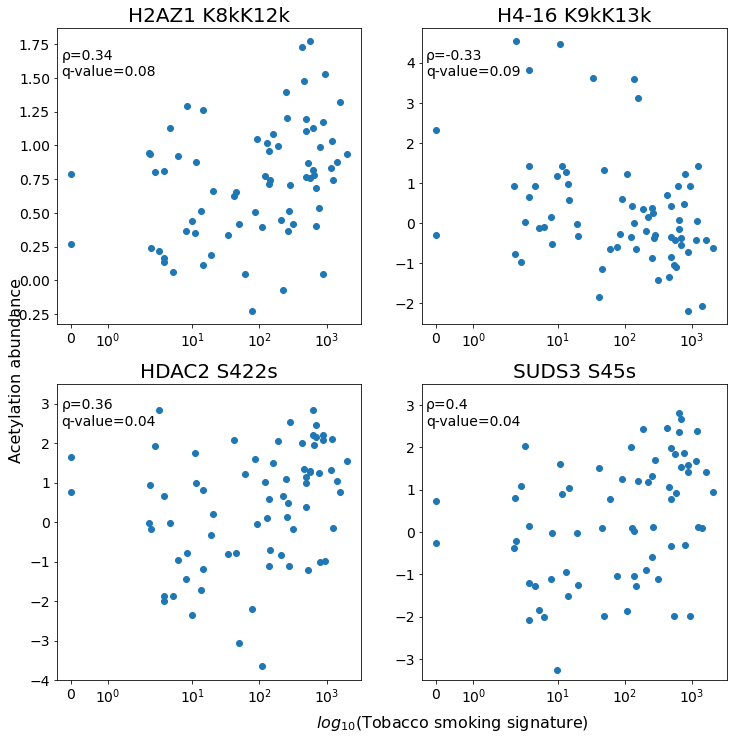

In [169]:
scatter_fig, scatter_ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))

# H2AZ1 K8 K12 acetylation
asite1 = 'NP_002097.1_K8kK12k_2_2_8_12'
geneSymbol = var_map.loc[asite1, 'geneSymbol']
acetylsites = asite1.split('_')[2]
include_luad_s = luad_raw_res_acetyl_df.loc[luad_s][asite1].dropna().index
scatter_ax[0][0].scatter(H_mut.loc[luad_s]['Tobacco Smoking'], 
                      luad_raw_res_acetyl_df.loc[luad_s][asite1])
a_corr, a_p = spearmanr(H_mut.loc[include_luad_s]['Tobacco Smoking'].dropna(), 
                        luad_raw_res_acetyl_df.loc[include_luad_s][asite1].dropna())
qvalue = round(luad_corr_df.loc[asite1, 'adj.P.Val'], 2)
scatter_ax[0][0].set_xscale('symlog')
scatter_ax[0][0].set_title(f"{geneSymbol} {acetylsites}", size=20)
scatter_fig.text(s=f"ρ={round(a_corr,2)}\nq-value={qvalue}", x=0.13, y=0.825, fontsize=14)
scatter_ax[0][0].tick_params(axis='x', labelsize=14)
scatter_ax[0][0].tick_params(axis='y', labelsize=14)

# H4-16 K9 K13
asite2 = 'NP_001029249.1_K9kK13k_2_2_9_13'
geneSymbol = var_map.loc[asite2, 'geneSymbol']
acetylsites = asite2.split('_')[2]
include_luad_s = luad_raw_res_acetyl_df.loc[luad_s][asite2].dropna().index
scatter_ax[0][1].scatter(H_mut.loc[luad_s]['Tobacco Smoking'], 
                      luad_raw_res_acetyl_df.loc[luad_s][asite2])
a_corr, a_p = spearmanr(H_mut.loc[include_luad_s]['Tobacco Smoking'].dropna(), 
                        luad_raw_res_acetyl_df.loc[include_luad_s][asite2].dropna())
qvalue = round(luad_corr_df.loc[asite2, 'adj.P.Val'], 2)
scatter_ax[0][1].set_xscale('symlog')
scatter_ax[0][1].set_title(f"{geneSymbol} {acetylsites}", size=20)
scatter_fig.text(s=f"ρ={round(a_corr,2)}\nq-value={qvalue}", x=0.552, y=0.825, fontsize=14)
scatter_ax[0][1].tick_params(axis='x', labelsize=14)
scatter_ax[0][1].tick_params(axis='y', labelsize=14)

# HDAC2 S422 phosphorylation
# phospho_site = 'NP_036370.2_S26s_1_1_26_26'
phospho_site = 'NP_001518.3_S422s_1_1_422_422'
geneSymbol = var_map.loc[phospho_site, 'geneSymbol']
phosphosites = phospho_site.split('_')[2]

include_luad_s = luad_raw_res_phospho_df.loc[luad_s][phospho_site].dropna().index
scatter_ax[1][0].scatter(H_mut.loc[luad_s]['Tobacco Smoking'], 
                         luad_raw_res_phospho_df.loc[luad_s][phospho_site])
p_corr, p_p = spearmanr(H_mut.loc[include_luad_s]['Tobacco Smoking'], 
                        luad_raw_res_phospho_df.loc[include_luad_s][phospho_site])
scatter_ax[1][0].set_title(f"{geneSymbol} {phosphosites}", size=20)
scatter_ax[1][0].set_xscale('symlog')
qvalue = round(luad_hdac_phospho_res_corr_df.loc[phospho_site,'adj.P.Val'],2)
scatter_fig.text(s=f"ρ={round(p_corr,2)}\nq-value={qvalue}", x=0.13, y=0.42, fontsize=14)
scatter_ax[1][0].tick_params(axis='x', labelsize=14) 
scatter_ax[1][0].tick_params(axis='y', labelsize=14)
scatter_ax[1][0].set_ylim((-4, 3.5))

# SUDS3 S45 phosphorlation
asite3 = "NP_071936.2_S45s_1_1_45_45"
geneSymbol = var_map.loc[asite3, 'geneSymbol']
acetylsites = asite3.split('_')[2]
include_luad_s = luad_raw_res_phospho_df.loc[luad_s][asite3].dropna().index
scatter_ax[1][1].scatter(H_mut.loc[luad_s]['Tobacco Smoking'], 
                         luad_raw_res_phospho_df.loc[luad_s][asite3])
a_corr, a_p = spearmanr(H_mut.loc[include_luad_s]['Tobacco Smoking'].dropna(), 
                        luad_raw_res_phospho_df.loc[include_luad_s][asite3].dropna())
qvalue = round(luad_hdac_phospho_res_corr_df.loc[asite3, 'adj.P.Val'], 2)
scatter_ax[1][1].set_xscale('symlog')
scatter_ax[1][1].set_title(f"{geneSymbol} {acetylsites}", size=20)
scatter_fig.text(s=f"ρ={round(a_corr,2)}\nq-value={qvalue}", x=0.552, y=0.42, fontsize=14)
scatter_ax[1][1].tick_params(axis='x', labelsize=14)
scatter_ax[1][1].tick_params(axis='y', labelsize=14)
scatter_ax[1][1].set_ylim((-3.5, 3.5))

scatter_fig.text(s="$log_{10}$(Tobacco smoking signature)", 
                 y=0.07, x=0.425, size=16)
scatter_fig.text(s="Acetylation abundance", 
                 y=0.38, x=0.07, size=16, rotation=90)

scatter_fig.savefig("../figures/histone_analysis/smoking_histone_correlations_v2.pdf",
                    dpi=100, bbox_inches='tight')

## 4 ssGSEA correlations
Restrict to male LSCC and LUAD

In [8]:
include_s = pd.Series(luad_s.to_list() + lscc_s.to_list())

pathway_corr_d = {}
for pathway in ssgsea_uniq_rna.columns.to_list():
    corr, pval = spearmanr(H_mut.loc[include_s]['Tobacco Smoking'], 
                           ssgsea_uniq_rna.loc[include_s][pathway])
    pathway_corr_d[pathway] = {"corr":corr, "pval":pval}
pathway_corr_df = pd.DataFrame.from_dict(pathway_corr_d).T
pathway_corr_df['adj.P.Val'] = multipletests(pathway_corr_df['pval'], method='fdr_bh')[1]
pathway_corr_df.to_csv("../results/histone_tobacco/smoking_gsea_corr_v2.tsv", 
                       sep='\t')
pathway_corr_df[pathway_corr_df['adj.P.Val']<=0.05].sort_values('corr')


,corr,pval,adj.P.Val
HALLMARK_NOTCH_SIGNALING,-0.314505,0.000060,0.001508
HALLMARK_IL2_STAT5_SIGNALING,-0.279219,0.000398,0.005170
HALLMARK_UV_RESPONSE_DN,-0.237821,0.002707,0.016916
HALLMARK_XENOBIOTIC_METABOLISM,-0.234658,0.003095,0.017192
HALLMARK_TGF_BETA_SIGNALING,-0.229154,0.003891,0.019455
HALLMARK_ANDROGEN_RESPONSE,-0.205078,0.009980,0.041583
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.224062,0.004787,0.021760
HALLMARK_E2F_TARGETS,0.253614,0.001351,0.009649
HALLMARK_G2M_CHECKPOINT,0.259635,0.001024,0.008537
HALLMARK_MTORC1_SIGNALING,0.272608,0.000552,0.005521


Correlation between tobacco smoking and G2M checkpoint:
	 rho: 0.01, p-val: 0.9
Correlation between tobacco smoking and MTOR signaling:
	 rho: 0.08, p-val: 0.44


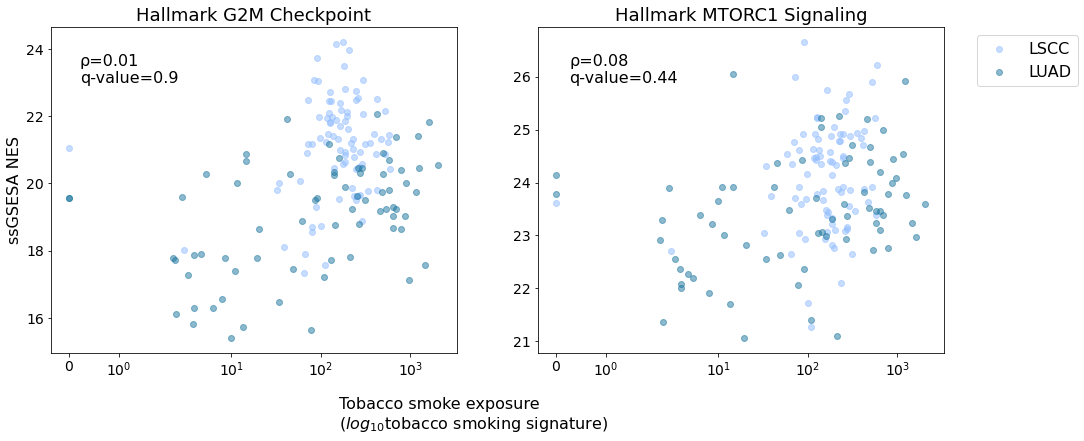

In [38]:
sample2Cohort_d = sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort']
color_s = include_s.map(sample2Cohort_d)
color_d = {'LUAD':"#1a759f", 'LSCC':"#91bdff"}
color_s = color_s.map(color_d)
cohort_d = {'LSCC':lscc_s, 'LUAD':luad_s}

ssgsea_fig, ssgsea_ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

for cohort in ['LSCC', 'LUAD']:
    ssgsea_ax[0].scatter(H_mut.loc[cohort_d[cohort]]['Tobacco Smoking'], 
                         ssgsea_uniq_rna.loc[cohort_d[cohort]]['HALLMARK_G2M_CHECKPOINT'], 
                         c=color_d[cohort], label=cohort, alpha=0.5)
    ssgsea_ax[0].set_xscale('symlog')
    ssgsea_ax[0].set_ylabel("ssGSESA NES", size=16)
    ssgsea_ax[0].set_title("Hallmark G2M Checkpoint", size=18)
    ssgsea_ax[0].tick_params(axis='x', labelsize=14)
    ssgsea_ax[0].tick_params(axis='y', labelsize=14)

    ssgsea_ax[1].scatter(H_mut.loc[cohort_d[cohort]]['Tobacco Smoking'], 
                         ssgsea_uniq_rna.loc[cohort_d[cohort]]['HALLMARK_MTORC1_SIGNALING'], 
                         c=color_d[cohort], label=cohort, alpha=0.5)
    ssgsea_ax[1].set_xscale('symlog')
    ssgsea_ax[1].set_title("Hallmark MTORC1 Signaling", size=18)
    ssgsea_ax[1].tick_params(axis='x', labelsize=14)
    ssgsea_ax[1].tick_params(axis='y', labelsize=14)
    
ssgsea_fig.text(s="Tobacco smoke exposure\n($log_{10}$tobacco smoking signature)", y=-0.05, x=0.375, size=16)
ssgsea_ax[1].legend(bbox_to_anchor=(0.85, 0.5, 0.5, 0.5), fontsize=16)

g2m_smoke_corr = round(pathway_corr_df.loc['HALLMARK_G2M_CHECKPOINT', 'corr'],2)
g2m_smoke_qval = round(pathway_corr_df.loc['HALLMARK_G2M_CHECKPOINT', 'adj.P.Val'],2)
mtor_smoke_corr = round(pathway_corr_df.loc['HALLMARK_MTORC1_SIGNALING', 'corr'], 2)
mtor_smoke_qval = round(pathway_corr_df.loc['HALLMARK_MTORC1_SIGNALING', 'adj.P.Val'], 2)

print(f"Correlation between tobacco smoking and G2M checkpoint:\n\t rho: {round(g2m_smoke_corr,2)}, p-val: {g2m_smoke_qval}")
print(f"Correlation between tobacco smoking and MTOR signaling:\n\t rho: {round(mtor_smoke_corr,2)}, p-val: {mtor_smoke_qval}")
ssgsea_fig.text(s=f"ρ={g2m_smoke_corr}\nq-value={g2m_smoke_qval}", x=0.15, y=0.75, fontsize=16)
ssgsea_fig.text(s=f"ρ={mtor_smoke_corr}\nq-value={mtor_smoke_qval}", x=0.575, y=0.75, fontsize=16)
ssgsea_fig.savefig('../figures/histone_tobacco_analysis/smoking_proliferation_gsea_v2.pdf', 
                   dpi=100, bbox_inches='tight')
ssgsea_fig.savefig('../figures/histone_analysis/smoking_proliferation_gsea_v2.pdf', 
                   dpi=100, bbox_inches='tight')